from .pt folder

In [1]:
import torch

ckpt = torch.load("final_checkpoint.pt", map_location="cpu")

print(type(ckpt))

if isinstance(ckpt, dict):
    print(ckpt.keys())

<class 'dict'>
dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss'])


In [2]:
import torch

ckpt = torch.load("final_checkpoint.pt", map_location="cpu")

print("Last epoch:", ckpt["epoch"])
print("Train loss:", ckpt["train_loss"])
print("Val loss:", ckpt["val_loss"])


Last epoch: 3
Train loss: 0.5000576014062645
Val loss: 0.4269264387957593


In [3]:
from transformers import Blip2ForConditionalGeneration, Blip2Processor
import torch

model_name = "Salesforce/blip2-opt-2.7b"

processor = Blip2Processor.from_pretrained(model_name)

model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)



e:\.RAKSHYA\Neural Network\VQAv2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 
Loading weights: 100%|██████████| 1247/1247 [00:02<00:00, 578.69it/s, Materializing param=vision_model.post_layernorm.weight]                               


In [4]:
missing, unexpected = model.load_state_dict(
    ckpt["model_state_dict"],
    strict=False
)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)


Missing keys: []
Unexpected keys: []


Import Libraries

In [5]:
import torch
from transformers import Blip2ForConditionalGeneration, Blip2Processor
from PIL import Image
from pathlib import Path
import json
import random
from collections import Counter
import numpy as np

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

val_img_dir = Path(r"E:\.RAKSHYA\Neural Network\VQAv2\val2014")
questions_file = Path(r"E:\.RAKSHYA\Neural Network\VQAv2\annotations\v2_OpenEnded_mscoco_val2014_questions.json")
annotations_file = Path(r"E:\.RAKSHYA\Neural Network\VQAv2\annotations\v2_mscoco_val2014_annotations.json")
checkpoint_file = Path(r"E:\.RAKSHYA\Neural Network\VQAv2\final_checkpoint.pt")  


In [7]:
# Load your fine-tuned weights
ckpt = torch.load(checkpoint_file, map_location=device)
model.load_state_dict(ckpt["model_state_dict"], strict=False)

# Freeze vision and language backbone 
for param in model.vision_model.parameters():
    param.requires_grad = False
for param in model.language_model.parameters():
    param.requires_grad = False


In [8]:
with open(questions_file, "r", encoding="utf-8") as f:
    questions_data = json.load(f)["questions"]

with open(annotations_file, "r", encoding="utf-8") as f:
    annotations_data = json.load(f)["annotations"]

# Map question_id to list of 10 human answers
full_annotation_map = {ann["question_id"]: [a["answer"].lower().strip() for a in ann["answers"]] for ann in annotations_data}

# Build a VQAv2 answer vocabulary
answer_vocab = set()
for ans_list in full_annotation_map.values():
    answer_vocab.update(ans_list)

Post-processing & short-answer generation

In [9]:
def generate_answer(image_path, question, vocab):
    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Image not found: {image_path}, skipping...")
        return None

    # Prompt template
    prompt = f"Question: {question}\nAnswer:"
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=5, 
            num_beams=3,
            do_sample=False,
            early_stopping=True
        )

    ans = processor.decode(output[0], skip_special_tokens=True).lower().strip()

    if prompt.lower() in ans:
        ans = ans[len(prompt):].strip(" ?.:\"")

    if ans in vocab:
        return ans
    else:
        for word in vocab:
            if word in ans:
                return word
        return ans.split()[0] if len(ans.split()) > 0 else ans

VQA accuracy function

In [10]:
def vqa_accuracy(pred_answer, gt_answers):
    counts = Counter(gt_answers)
    matching = counts.get(pred_answer.lower().strip(), 0)
    return min(matching / 3, 1.0)

Evaluation on Random Samples

In [11]:
def evaluate_vqa(samples, num_samples=20):
    scores = []
    evaluated = 0
    random.shuffle(samples)  

    for sample in samples:
        if evaluated >= num_samples:
            break

        qid = sample["question_id"]
        img_id = sample["image_id"]
        question = sample["question"]
        img_file = val_img_dir / f"COCO_val2014_{img_id:012d}.jpg"

        if not img_file.exists():
            continue

        pred_answer = generate_answer(img_file, question, answer_vocab)
        if pred_answer is None:
            continue

        gt_answers = full_annotation_map.get(qid, [])
        acc = vqa_accuracy(pred_answer, gt_answers)

        scores.append(acc)
        evaluated += 1

        print(f"Image ID: {img_id}")
        print(f"Question: {question}")
        print(f"Predicted Answer: {pred_answer}")
        print(f"Ground Truth Answers: {gt_answers}")
        print(f"VQA Accuracy: {acc:.2f}")
        print("-" * 50)

    avg_acc = np.mean(scores) if scores else 0.0
    print(f"\nAverage VQA Accuracy over {evaluated} samples: {avg_acc:.3f}")
    return avg_acc

In [12]:

avg_accuracy = evaluate_vqa(questions_data, num_samples=20)

Image ID: 178446
Question: What is on the back of the man's shirt?
Predicted Answer: hat
Ground Truth Answers: ["o'neill", "o'neill", 'oneil logo', "o'neill california", "o'neill logo", "o'neill", 'snake', "o'neill california", "o'neill", 'brand name']
VQA Accuracy: 0.00
--------------------------------------------------
Image ID: 239992
Question: What is the plane on the left?
Predicted Answer: 747
Ground Truth Answers: ['delta', 'passenger', 'delta', 'delta', 'delta', 'delta', 'delta', 'delta', 'delta', 'aa']
VQA Accuracy: 0.00
--------------------------------------------------
Image ID: 5146
Question: How many horses?
Predicted Answer: 2
Ground Truth Answers: ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2']
VQA Accuracy: 1.00
--------------------------------------------------
Image ID: 532732
Question: What color is the hat?
Predicted Answer: red
Ground Truth Answers: ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
VQA Accuracy: 1.00
------------------------

Evaliation With Visualization

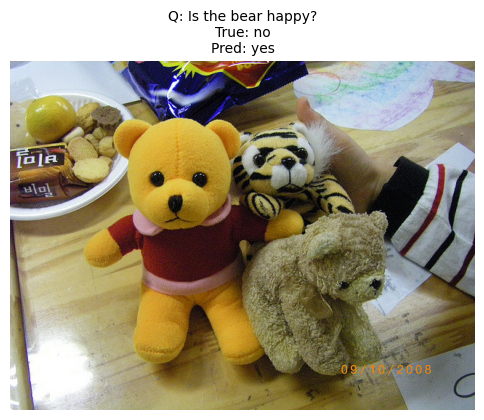

Image ID: 47225
Question: Is the bear happy?
Predicted Answer: yes
Ground Truth Answers: ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no']
VQA Accuracy: 0.33
--------------------------------------------------


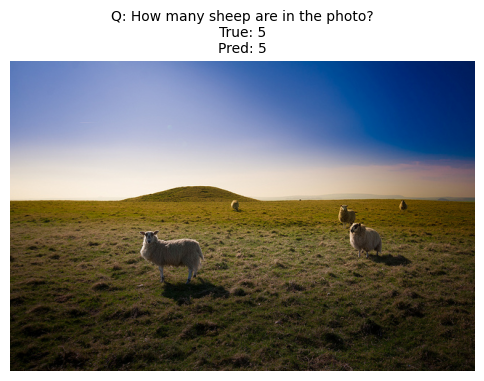

Image ID: 152731
Question: How many sheep are in the photo?
Predicted Answer: 5
Ground Truth Answers: ['5', '5', '5', '5', '5', '5', '5', '5', '5', '5']
VQA Accuracy: 1.00
--------------------------------------------------


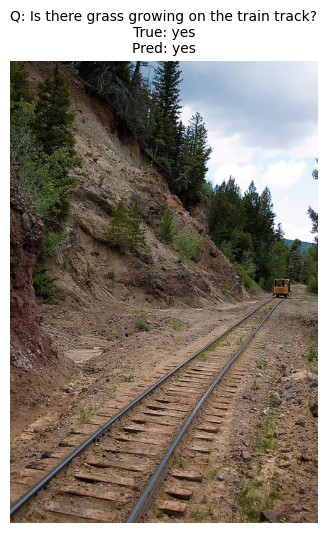

Image ID: 508996
Question: Is there grass growing on the train track?
Predicted Answer: yes
Ground Truth Answers: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
VQA Accuracy: 1.00
--------------------------------------------------


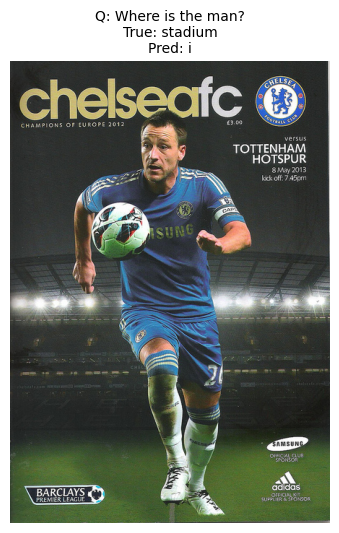

Image ID: 576463
Question: Where is the man?
Predicted Answer: i
Ground Truth Answers: ['stadium', 'tottenham', 'soccer field', 'on magazine', 'soccer field', 'soccer field', 'soccer field', 'on field', 'stadium', 'soccer stadium']
VQA Accuracy: 0.00
--------------------------------------------------


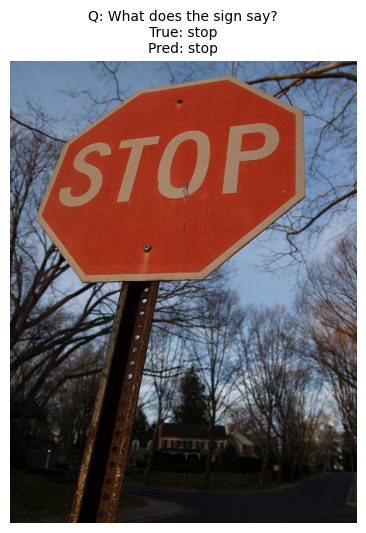

Image ID: 85529
Question: What does the sign say?
Predicted Answer: stop
Ground Truth Answers: ['stop', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop', 'stop']
VQA Accuracy: 1.00
--------------------------------------------------

Average VQA Accuracy over 5 samples: 0.667


In [ ]:
import matplotlib.pyplot as plt

def evaluate_vqa_visual(samples, num_samples=20):
    scores = []
    evaluated = 0
    random.shuffle(samples)  

    for sample in samples:
        if evaluated >= num_samples:
            break

        qid = sample["question_id"]
        img_id = sample["image_id"]
        question = sample["question"]
        img_file = val_img_dir / f"COCO_val2014_{img_id:012d}.jpg"

        if not img_file.exists():
            continue

        # Generate predicted answer
        pred_answer = generate_answer(img_file, question, answer_vocab)
        if pred_answer is None:
            continue

        # Get ground truth answers
        gt_answers = full_annotation_map.get(qid, [])
        acc = vqa_accuracy(pred_answer, gt_answers)
        scores.append(acc)
        evaluated += 1

    
        image = Image.open(img_file).convert("RGB")
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Q: {question}\nTrue: {gt_answers[0] if gt_answers else 'N/A'}\nPred: {pred_answer}", fontsize=10)
        plt.show()

        # Also print textual info in console
        print(f"Image ID: {img_id}")
        print(f"Question: {question}")
        print(f"Predicted Answer: {pred_answer}")
        print(f"Ground Truth Answers: {gt_answers}")
        print(f"VQA Accuracy: {acc:.2f}")
        print("-" * 50)

    avg_acc = np.mean(scores) if scores else 0.0
    print(f"\nAverage VQA Accuracy over {evaluated} samples: {avg_acc:.3f}")
    return avg_acc

# Run the visual evaluation
avg_accuracy_visual = evaluate_vqa_visual(questions_data, num_samples=5)  


VQA accuracy

In [ ]:
import csv

def evaluate_vqa_large(samples, num_samples=2000, save_csv=True):
    scores = []
    evaluated = 0
    results = []

    # Shuffle questions and select 2000
    random.shuffle(samples)
    samples = samples[:num_samples]

    for sample in samples:
        qid = sample["question_id"]
        img_id = sample["image_id"]
        question = sample["question"]
        img_file = val_img_dir / f"COCO_val2014_{img_id:012d}.jpg"

        if not img_file.exists():
            continue

        pred_answer = generate_answer(img_file, question, answer_vocab)
        if pred_answer is None:
            continue

        gt_answers = full_annotation_map.get(qid, [])
        acc = vqa_accuracy(pred_answer, gt_answers)
        scores.append(acc)
        evaluated += 1

        # Store results for CSV/report
        results.append({
            "image_id": img_id,
            "question": question,
            "predicted_answer": pred_answer,
            "ground_truth_answers": "|".join(gt_answers),
            "vqa_accuracy": acc
        })

        if evaluated % 50 == 0:
            print(f"Processed {evaluated}/{num_samples} samples...")

    avg_acc = np.mean(scores) if scores else 0.0
    print(f"\nAverage VQA Accuracy over {evaluated} samples: {avg_acc:.3f}")

    # Save results to CSV if needed
    if save_csv:
        csv_file = "vqa_2000_results.csv"
        with open(csv_file, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=results[0].keys())
            writer.writeheader()
            for row in results:
                writer.writerow(row)
        print(f"Results saved to {csv_file}")

    return avg_acc


# Run evaluation
avg_accuracy_2000 = evaluate_vqa_large(questions_data, num_samples=2000)

Processed 50/2000 samples...
Processed 100/2000 samples...
Processed 150/2000 samples...
Processed 200/2000 samples...
Processed 250/2000 samples...
Processed 300/2000 samples...
Processed 350/2000 samples...
Processed 400/2000 samples...
Processed 450/2000 samples...
Processed 500/2000 samples...
Processed 550/2000 samples...
Processed 600/2000 samples...
Processed 650/2000 samples...
Processed 700/2000 samples...
Processed 750/2000 samples...
Processed 800/2000 samples...
Processed 850/2000 samples...
Processed 900/2000 samples...
Processed 950/2000 samples...
Processed 1000/2000 samples...
Processed 1050/2000 samples...
Processed 1100/2000 samples...
Processed 1150/2000 samples...
Processed 1200/2000 samples...
Processed 1250/2000 samples...
Processed 1300/2000 samples...
Processed 1350/2000 samples...
Processed 1400/2000 samples...
Processed 1450/2000 samples...
Processed 1500/2000 samples...
Processed 1550/2000 samples...
Processed 1600/2000 samples...
Processed 1650/2000 samples.